In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [2]:
import os
import sys

inference_ipynb_path='/root/code/SimpleAICV_pytorch_training_examples/13.interactive_segmentation_training/sam_predict_example/sam_predict_everything_example.ipynb'
BASE_DIR = os.path.dirname(
    os.path.dirname(os.path.dirname(inference_ipynb_path)))
sys.path.append(BASE_DIR)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torch.nn as nn
import torch.nn.functional as F

from simpleAICV.interactive_segmentation.models.segment_anything.sam import sam_h
from simpleAICV.interactive_segmentation.common import load_state_dict


sam_checkpoint = '/root/autodl-tmp/pretrained_models/sam_official_pytorch_weights/sam_vit_h_4b8939.pth'

sam_model = sam_h(image_size=1024, 
                  patch_size=16,                 
                  use_gradient_checkpoint=False,
                  frozen_image_encoder=False,
                  frozen_prompt_encoder=False,
                  frozen_mask_decoder=False,
                  sigmoid_out=False,
                  binary_mask_out=False,
                  mask_threshold=0.0)
sam_model = sam_model.cuda()
sam_model = sam_model.eval()

load_state_dict(sam_checkpoint,sam_model)

load/model weight nums:594/594
not loaded save layer weight:
[]


(603, 1072, 3) uint8


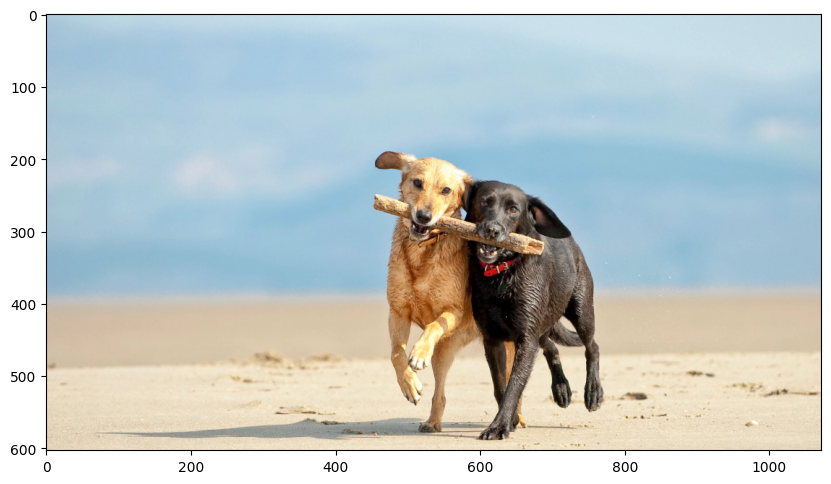

In [3]:
test_image_path='/root/code/SimpleAICV_pytorch_training_examples/13.interactive_segmentation_training/sam_predict_example/test_images/dogs.jpg'
origin_image = cv2.imdecode(np.fromfile(test_image_path, dtype=np.uint8),
                        cv2.IMREAD_COLOR)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)
print(origin_image.shape,origin_image.dtype)

plt.figure(figsize=(10,10))
plt.imshow(origin_image)
plt.axis('on')
plt.show()

(576, 1024, 3) uint8 0.9552238805970149


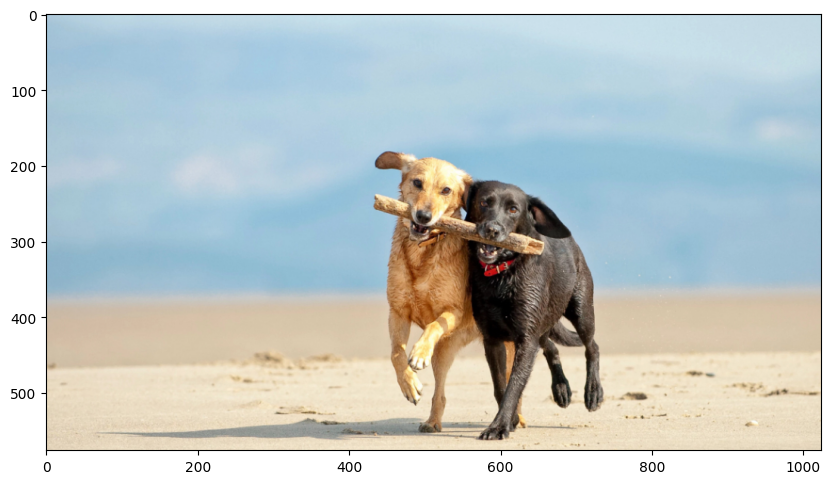

(576, 1024, 3) 2.64 -2.1179039301310043
(1024, 1024, 3) 2.64 -2.117904
torch.Size([1, 3, 1024, 1024]) tensor(2.6400, device='cuda:0') tensor(-2.1179, device='cuda:0')


In [4]:
origin_h, origin_w = origin_image.shape[0], origin_image.shape[1]
factor = 1024 / max(origin_h, origin_w)
resize_h, resize_w = int(round(origin_h * factor)), int(
    round(origin_w * factor))
resized_image = cv2.resize(origin_image, (resize_w, resize_h))
print(resized_image.shape,resized_image.dtype,factor)

plt.figure(figsize=(10, 10))
plt.imshow(resized_image)
plt.axis('on')
plt.show()

mean = [123.675, 116.28, 103.53]
std = [58.395, 57.12, 57.375]
norm_image = (resized_image - mean) / std
print(norm_image.shape,np.max(norm_image),np.min(norm_image))

padded_img = np.zeros((max(resize_h, resize_w), max(resize_h, resize_w), 3),
                        dtype=np.float32)
padded_img[:resize_h, :resize_w, :] = norm_image
print(padded_img.shape,np.max(padded_img),np.min(padded_img))


padded_img = torch.tensor(padded_img).float().cuda().permute(2, 0, 1).unsqueeze(0)
print(padded_img.shape,torch.max(padded_img),torch.min(padded_img))

32 603 1072 (1024, 2) (1024, 1)
(1024, 3)


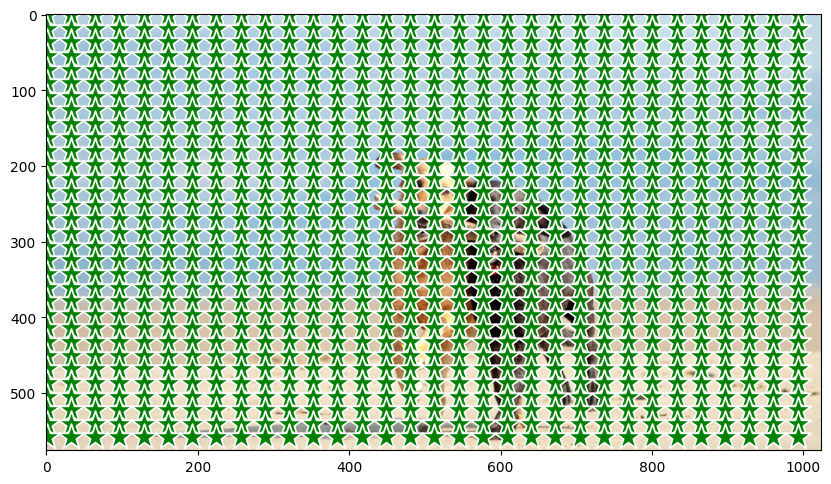

In [5]:
grid_size=32
positive_grid_points = []
positive_grid_labels=[]
for i in range(grid_size):
    per_point_x = 0.5 + i / grid_size * origin_w
    for j in range(grid_size):
        per_point_y = 0.5 + j / grid_size * origin_h
        positive_grid_points.append([per_point_x, per_point_y])
        positive_grid_labels.append([1])

positive_grid_points=np.array(positive_grid_points)*factor
positive_grid_labels=np.array(positive_grid_labels)
print(grid_size,origin_h,origin_w,positive_grid_points.shape,positive_grid_labels.shape)

prompt_points=np.concatenate([positive_grid_points,positive_grid_labels],axis=1)
print(prompt_points.shape)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_points(positive_grid_points, np.squeeze(positive_grid_labels,axis=1), plt.gca())
plt.axis('on')
plt.show()

In [6]:
per_image=padded_img.clone()

with torch.no_grad():
    per_image_embedding=sam_model.forward_per_image_encoder(per_image)
print(per_image_embedding.shape)

batch_prompts=[]
for per_point in prompt_points:
    per_point=np.expand_dims(per_point,axis=0)
    per_point = torch.tensor(np.expand_dims(per_point,axis=0)).float().cuda()
    batch_prompts.append({'prompt_point':per_point,
                          'prompt_box':None,
                          'prompt_mask':None})

print(len(batch_prompts),batch_prompts[0]['prompt_point'].shape)

mask_out_idxs=[3]
with torch.no_grad():
    batch_mask_outputs, batch_iou_outputs = sam_model.forward_per_image_prompt_encoder_mask_decoder(per_image_embedding, batch_prompts, mask_out_idxs=mask_out_idxs)
    batch_mask_outputs = batch_mask_outputs.squeeze(dim=1)
    batch_iou_outputs = batch_iou_outputs.squeeze(dim=1)
print(batch_mask_outputs.shape,batch_iou_outputs.shape,batch_iou_outputs[0])

combine_mask_outputs = batch_mask_outputs.cpu().numpy()
combine_iou_outputs = batch_iou_outputs.cpu().numpy()
# [mask_num,mask_h,mask_w],[mask_num]
print(combine_mask_outputs.shape,combine_iou_outputs.shape,combine_iou_outputs[0])

torch.Size([1, 256, 64, 64])
1024 torch.Size([1, 1, 3])
torch.Size([1024, 1024, 1024]) torch.Size([1024]) tensor(0.9536, device='cuda:0')
(1024, 1024, 1024) (1024,) 0.9535961


In [7]:
def calculate_masks_stability_score(masks, mask_threshold, threshold_offset):
    """
    Computes the stability score for a batch of masks. The stability
    score is the IoU between the binary masks obtained by thresholding
    the predicted mask logits at high and low values.
    """
    intersections = np.sum(np.sum((masks >
                                   (mask_threshold + threshold_offset)),
                                  axis=-1),
                           axis=-1)
    unions = np.sum(np.sum((masks > (mask_threshold - threshold_offset)),
                           axis=-1),
                    axis=-1)

    return intersections / unions


def filter_small_area_masks(masks, ious, filter_area_ratio=0.0001):
    per_mask_h, per_mask_w = masks.shape[1], masks.shape[2]
    masks_area = np.sum(masks, axis=(1, 2))

    keep_masks = []
    keep_ious = []
    for per_mask_area, per_mask, per_iou in zip(masks_area, masks, ious):
        per_mask_area_ratio = per_mask_area / float(per_mask_h * per_mask_w)

        if per_mask_area_ratio > filter_area_ratio:
            keep_masks.append(per_mask)
            keep_ious.append(per_iou)

    keep_masks = np.array(keep_masks)
    keep_ious = np.array(keep_ious)

    return keep_masks, keep_ious


def fill_masks_hole(masks, fill_area_threshold=100):
    filled_masks = []
    for per_mask in masks:
        per_mask = per_mask.astype(np.uint8)
        # 取反mask,因为我们要填充的是前景中的空洞
        mask_invert = 1 - per_mask

        # 寻找连通区域
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            mask_invert, 8, cv2.CV_32S)

        # Row 0 is background label
        sizes = stats[:, -1][1:]
        small_regions = [
            i + 1 for i, s in enumerate(sizes) if s < fill_area_threshold
        ]
        if len(small_regions) == 0:
            filled_masks.append(per_mask)
        else:
            fill_labels = [0] + small_regions
            per_mask = np.isin(labels, fill_labels).astype(np.uint8)
            filled_masks.append(per_mask)

    filled_masks = np.array(filled_masks)

    return filled_masks


def calculate_mask_nms(sorted_masks, sorted_scores, nms_threshold=0.5):
    '''
    sorted_masks:[mask_nums,mask_h,mask_w]
    sorted_scores:[mask_nums],mask predict scores
    '''
    sorted_masks_area = np.sum(sorted_masks, axis=(1, 2))

    indexes = np.array([i for i in range(sorted_scores.shape[0])],
                       dtype=np.int32)

    keep = []
    while indexes.shape[0] > 0:
        keep_idx = indexes[0]
        keep.append(keep_idx)
        indexes = indexes[1:]
        if len(indexes) == 0:
            break

        keep_mask_area = sorted_masks_area[keep_idx]

        overlap_mask_area = np.sum((sorted_masks[keep_idx]
                                    & sorted_masks[indexes]),
                                   axis=(1, 2))
        union_mask_area = keep_mask_area + sorted_masks_area[
            indexes] - overlap_mask_area
        union_mask_area = np.maximum(union_mask_area, 1e-4)
        ious = overlap_mask_area / union_mask_area

        candidate_indexes = np.where(ious < nms_threshold)[0]
        indexes = indexes[candidate_indexes]

    keep = np.array(keep)

    return keep


def calculate_bounding_box_from_binary_masks(masks):
    boxes = []
    for per_mask in masks:
        # 使用np.nonzero找到所有1的位置
        per_mask_rows, per_mask_cols = np.nonzero(per_mask)

        # 计算最小外接矩形的边界
        x_min = np.min(per_mask_cols)
        y_min = np.min(per_mask_rows)
        x_max = np.max(per_mask_cols)
        y_max = np.max(per_mask_rows)
        boxes.append([x_min, y_min, x_max, y_max])

    boxes = np.array(boxes)

    return boxes


def calculate_boxes_nms(sorted_bboxes, sorted_scores, nms_threshold=0.5):
    '''
    sorted_bboxes:[anchor_nums,4],4:x_min,y_min,x_max,y_max
    sorted_scores:[anchor_nums],classification predict scores
    '''

    sorted_bboxes_wh = sorted_bboxes[:, 2:4] - sorted_bboxes[:, 0:2]
    sorted_bboxes_areas = sorted_bboxes_wh[:, 0] * sorted_bboxes_wh[:, 1]
    sorted_bboxes_areas = np.maximum(sorted_bboxes_areas, 0)

    indexes = np.array([i for i in range(sorted_scores.shape[0])],
                       dtype=np.int32)

    keep = []
    while indexes.shape[0] > 0:
        keep_idx = indexes[0]
        keep.append(keep_idx)
        indexes = indexes[1:]
        if len(indexes) == 0:
            break

        keep_box_area = sorted_bboxes_areas[keep_idx]

        overlap_area_top_left = np.maximum(sorted_bboxes[keep_idx, 0:2],
                                           sorted_bboxes[indexes, 0:2])
        overlap_area_bot_right = np.minimum(sorted_bboxes[keep_idx, 2:4],
                                            sorted_bboxes[indexes, 2:4])
        overlap_area_sizes = np.maximum(
            overlap_area_bot_right - overlap_area_top_left, 0)
        overlap_area = overlap_area_sizes[:, 0] * overlap_area_sizes[:, 1]

        # compute ious for top1 pred_bbox and the other pred_bboxes
        union_area = keep_box_area + sorted_bboxes_areas[indexes] - overlap_area
        union_area = np.maximum(union_area, 1e-4)
        ious = overlap_area / union_area

        candidate_indexes = np.where(ious < nms_threshold)[0]
        indexes = indexes[candidate_indexes]

    keep = np.array(keep)

    return keep

In [8]:
combine_mask_outputs=combine_mask_outputs[:,0:resize_h,0:resize_w]

iou_pred_filter_threshold=0.9
pred_masks = combine_mask_outputs[combine_iou_outputs>iou_pred_filter_threshold]
pred_ious = combine_iou_outputs[combine_iou_outputs>iou_pred_filter_threshold]
print('1111',pred_masks.shape,pred_ious.shape,pred_ious[0])

mask_stability_score_filter_threshold=0.9
pred_mask_stability_scores = calculate_masks_stability_score(pred_masks, 0.0, 1.0)
pred_masks = pred_masks[pred_mask_stability_scores>mask_stability_score_filter_threshold]
pred_ious = pred_ious[pred_mask_stability_scores>mask_stability_score_filter_threshold]
print('2222',pred_masks.shape,pred_ious.shape,pred_ious[0])

pred_masks= (pred_masks > 0).astype(np.uint8)
print('3333',pred_masks.shape,pred_ious.shape,pred_ious[0],np.unique(pred_masks))

fill_area_threshold=100
pred_masks=fill_masks_hole(pred_masks,fill_area_threshold=fill_area_threshold).astype(np.uint8)
print('4444',pred_masks.shape,pred_ious.shape,pred_ious[0],np.unique(pred_masks))

filter_area_ratio=0.0025
pred_masks,pred_ious=filter_small_area_masks(pred_masks, pred_ious, filter_area_ratio=filter_area_ratio)
print('5555',pred_masks.shape,pred_ious.shape,pred_ious[0],np.unique(pred_masks))

1111 (964, 576, 1024) (964,) 0.9535961
2222 (268, 576, 1024) (268,) 1.0139799
3333 (268, 576, 1024) (268,) 1.0139799 [0 1]
4444 (268, 576, 1024) (268,) 1.0139799 [0 1]
5555 (268, 576, 1024) (268,) 1.0139799 [0 1]


In [9]:
# descending sort
iou_sorted_indexes = np.argsort(-pred_ious)
pred_masks = pred_masks[iou_sorted_indexes]
pred_ious = pred_ious[iou_sorted_indexes]
print('6666',pred_masks.shape,pred_ious.shape,pred_ious[0])

nms_threshold=0.3
keep_mask_indexes=calculate_mask_nms(pred_masks, pred_ious, nms_threshold=nms_threshold)
pred_masks = pred_masks[keep_mask_indexes]
pred_ious = pred_ious[keep_mask_indexes]
print('7777',keep_mask_indexes.shape,pred_masks.shape,pred_ious.shape)

# nms_threshold=0.3
# pred_mask_boxes=calculate_bounding_box_from_binary_masks(pred_masks)
# keep_mask_indexes=calculate_boxes_nms(pred_mask_boxes, pred_ious, nms_threshold=nms_threshold)
# pred_masks = pred_masks[keep_mask_indexes]
# pred_ious = pred_ious[keep_mask_indexes]
# print('7777',pred_mask_boxes.shape,keep_mask_indexes.shape,pred_masks.shape,pred_ious.shape)

6666 (268, 576, 1024) (268,) 1.0195062
7777 (5,) (5, 576, 1024) (5,)


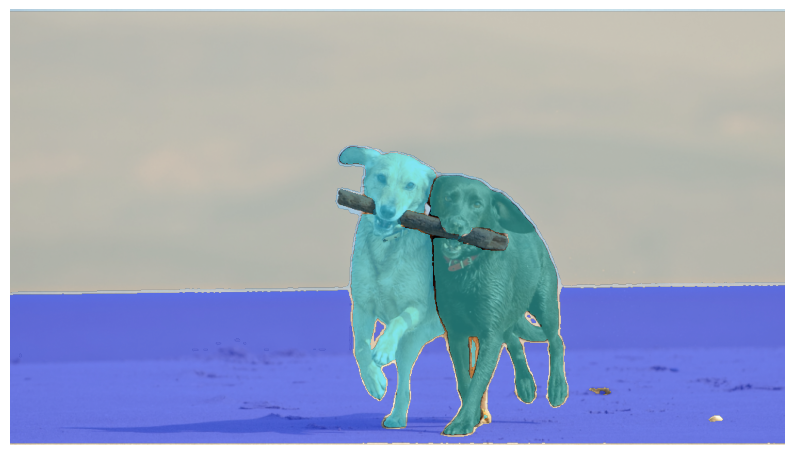

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(resized_image)
for i, per_mask in enumerate(pred_masks):
    show_mask(per_mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show()  